<center> <h1>Antoine ISNARDY</h1> </center>
<center> <h1>Data Camp - El Niño Data Challenge</h1> </center>
 
15 December 2016

In [1]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

## Summary

[1. Data exploration](#dataexp)<br>
[2. Pacific As A Graph (PaaG)](#paag)<br>
[3. Back to basics](#back)<br>
[4. Conclusion](#ccl)<br>

<a id='dataexp'></a>
## Data exploration
- Map monde
- El nino zone
- Correlations

In [2]:
X_ds = xr.open_dataset('el_nino_X_public_train.nc')
y_array = np.load('el_nino_y_public_train.npy')

### World map

In [3]:
# El nino zone
en=[-5, 5, 190, 240]
en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

# Around zones
bottom=[-15,-5,190,240]
up=[5, 15, 190, 240]
left=[-15,15,165,190]
right=[-15,15,240,265]

rectangle=[bottom[0], up[1], left[2], right[3]] # Including all zones

In [4]:
el_nino_lats = [en_lat_bottom, en_lat_top, en_lat_top, en_lat_bottom]
el_nino_lons = [en_lon_right, en_lon_right, en_lon_left, en_lon_left]

from matplotlib.patches import Polygon

def plot_map(X_ds, time_index):
    def draw_screen_poly(lats, lons, m):
        x, y = m(lons, lats)
        xy = list(zip(x, y))
        poly = Polygon(xy, edgecolor='black', fill=False)
        plt.gca().add_patch(poly)

    lons, lats = np.meshgrid(X_ds['lon'], X_ds['lat'])

    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9,0.9])
    map = Basemap(llcrnrlon=0, llcrnrlat=-89, urcrnrlon=360, urcrnrlat=89, projection='mill')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    #map.drawcountries(linewidth=0.25)
    #map.fillcontinents(color='coral',lake_color='aqua')
    # draw the edge of the map projection region (the projection limb)
    #map.drawmapboundary(fill_color='aqua')
    im = map.pcolormesh(
        lons, lats, X_ds[time_index] - 273.15, shading='flat', cmap=plt.cm.jet, latlon=True)
    cb = map.colorbar(im,"bottom", size="5%", pad="2%")
    draw_screen_poly(el_nino_lats, el_nino_lons, map)

    time_str = str(pd.to_datetime(str(X_ds['time'].values[time_index])))[:7]
    ax.set_title("Temperature map " + time_str)
    #plt.savefig("test_plot.pdf")
    plt.show()

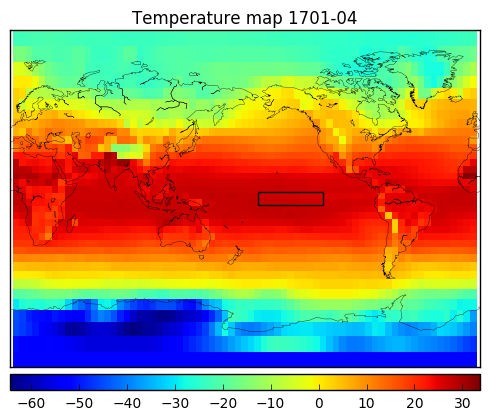

In [5]:
t = 15
plot_map(X_ds['tas'], t)

- As one may expect, temperature looks highly correlated to latitude ! Let's check whether it holds into the El Ninõ zone and around

In [6]:
def get_area(tas, coords):
    return tas.loc[:,coords[0]:coords[1], coords[2]:coords[3]]

def get_area_mean(area):
    """The array of mean temperatures in a region at all time points."""
    return area.mean(dim=('lat','lon'))

### El Niño zone

In [7]:
X_elninoZone = get_area(X_ds['tas'], rectangle)

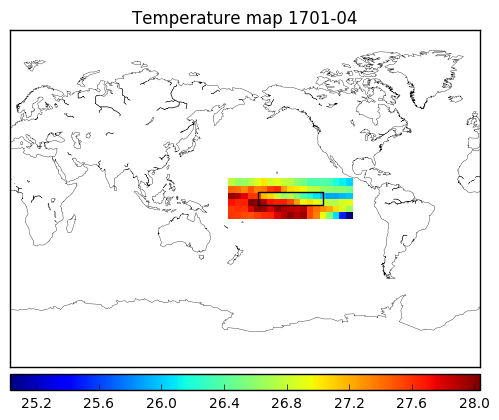

In [8]:
plot_map(X_elninoZone, t)

- At this particular date, the previous comment can be slightly qualified. Indeed temperatures are not uniformly distributed into the zone.

- Let dig a little bit into it and let's split the el nino zone into 4 zones (the 4 sub-rectangles), and let's compute the mean for each split

### Correlations

In [9]:
enso = get_area_mean(get_area(X_ds['tas'], en))
ul_enso = X_ds['tas'].loc[:, 0:5, 360-170:197.5].mean(dim=('lat', 'lon'))
ur_enso = X_ds['tas'].loc[:, 0:5, 197.5:360-120].mean(dim=('lat', 'lon'))
bl_enso = X_ds['tas'].loc[:, -5:0, 360-170:197.5].mean(dim=('lat', 'lon'))
br_enso = X_ds['tas'].loc[:, -5:0, 197.5:360-120].mean(dim=('lat', 'lon'))

array([[ 1.        ,  0.94125702],
       [ 0.94125702,  1.        ]])

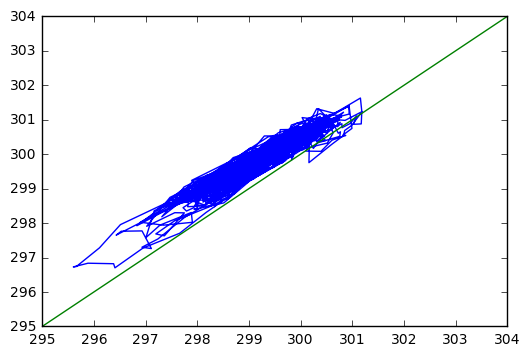

In [10]:
plt.plot(enso, ul_enso)
plt.plot(range(295,305), range(295,305))
np.corrcoef(enso,ul_enso)

array([[ 1.        ,  0.99181171],
       [ 0.99181171,  1.        ]])

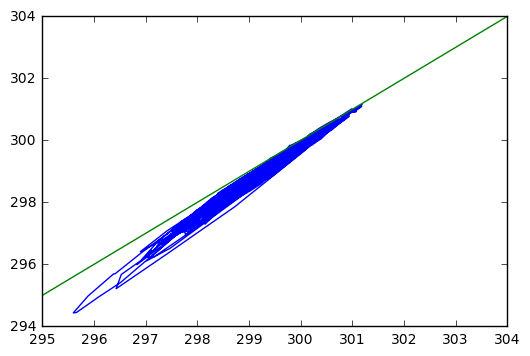

In [11]:
plt.plot(enso, ur_enso)
plt.plot(range(295,305), range(295,305))
np.corrcoef(enso, ur_enso)

array([[ 1.       ,  0.9461135],
       [ 0.9461135,  1.       ]])

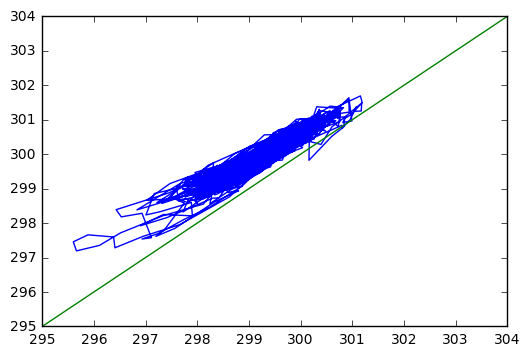

In [12]:
plt.plot(enso, bl_enso)
plt.plot(range(295,305), range(295,305))
np.corrcoef(enso, bl_enso)

array([[ 1.        ,  0.99543726],
       [ 0.99543726,  1.        ]])

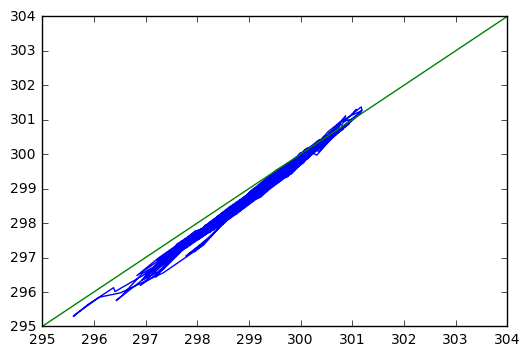

In [13]:
plt.plot(enso, br_enso)
plt.plot(range(295,305), range(295,305))
np.corrcoef(enso, br_enso)

- What comes out is that the temperature of the whole zone is not correlated in the same way to its subparts. For instance, the temperature in the top-right temperature looks highly correlated with the temperature of the whole zone, which leads to think that, as a first guess, the east part drives the temperature in the zone.
- Let's plot this guess.

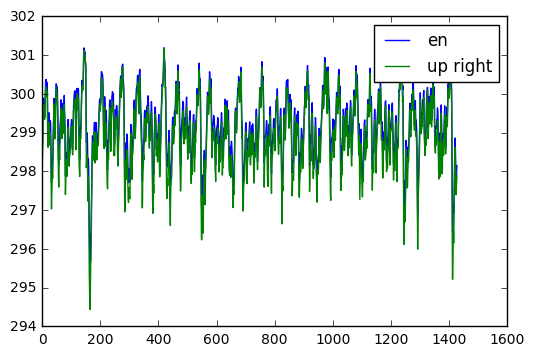

In [14]:
plt.plot(enso, label='en')
plt.plot(ur_enso, label='up right')
plt.legend()

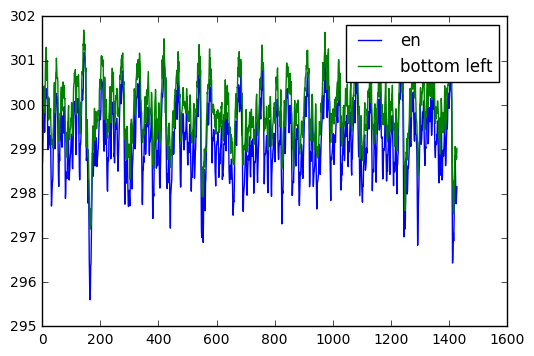

In [15]:
plt.plot(enso, label='en')
plt.plot(bl_enso, label='bottom left')
plt.legend()

- These two plots support the previous claim: temperatures in the east zone of EN are way more correlated to the temperature of the whole zone than the ones in the west zone.
- Given the bunch of time series we had at our disposal, I first looked at a way of summarizing it through correlations. This leads to my first approach, below.

<a id='paag'></a>
## First approach: Pacific As A Graph (PaaG)
- The idea of this approach mainly relies on ideas found at http://www.geosci-model-dev-discuss.net/gmd-2015-273/gmd-2015-273.pdf
- In a nutshell, it aims at:
    - Studying correlations in a grid of points, transformed into a graph.
    - Feeding regression techniques with variables depending on correlations (trees in my case)
---
- First step was then to transform the data into a graph of points.
- As suggested in the starting kit, I limited the grid to Pacific points, with El Nino points at the center. The graph looks like the picture below (it is not perfectly symetric in order to match coordinate system of X_ds)

In [16]:
class Physical_point:
    """
    Point defined by its latitute and longitude
    """
    def __init__(self, lat, lon):
        self.lat = lat
        self.lon = lon
        
en=[-5, 5, 190, 240] # El Nino zone

en_points = [Physical_point(5,192.5),
             Physical_point(5, 242.5),
             Physical_point(0, 212.5),
             Physical_point(-5, 192.5),
             Physical_point(-5, 242.5)]
pacific_points = [Physical_point(60, 212.5),
                  Physical_point(50, 162.5),
                  Physical_point(50, 262.5),
                  Physical_point(40, 212.5),
                  Physical_point(30, 162.5),
                  Physical_point(30, 262.5),
                  Physical_point(20, 212.5),
                  Physical_point(10, 262.5),
                  Physical_point(10, 162.5),
                  Physical_point(-10, 262.5),
                  Physical_point(-10, 162.5),
                  Physical_point(-20, 212.5),
                  Physical_point(-30, 262.5),
                  Physical_point(-30, 162.5),
                  Physical_point(-40, 212.5),
                  Physical_point(-50, 162.5),
                  Physical_point(-50, 262.5),
                  Physical_point(-60, 212.5),
                  Physical_point(0, 162.5),
                  Physical_point(0, 262.5)]

- Let's represent data as a graph

El Nino color: yellow
Pacific color: darkred


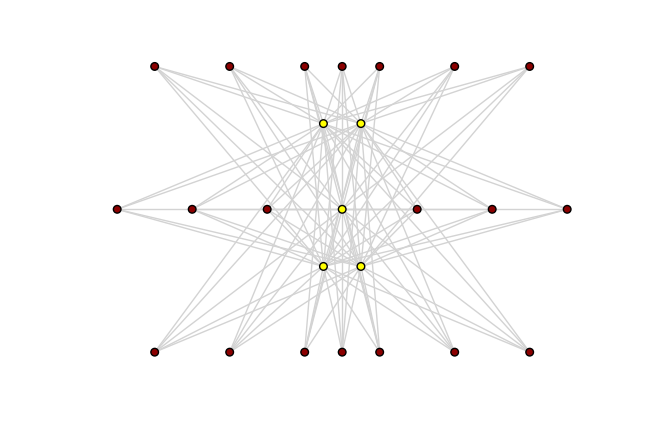

In [17]:
import networkx as nx
pos = {}
for i in range(len(en_points)):
    en_point = en_points[i]
    lat = en_point.lat
    lon = en_point.lon
    pos[i] = (lat, lon)
for i in range(len(pacific_points)):
    en_point = pacific_points[i]
    lat = en_point.lat
    lon = en_point.lon
    pos[i + len(en_points)] = (lat, lon)
    
edges = []
for i in range(len(en_points)):
    for j in range(len(pacific_points)):
        edges.append((i, j + len(en_points)))

en_color = 'yellow'
p_color = 'darkred'
G = nx.Graph()
for i in range(len(en_points) + len(pacific_points)): G.add_node(i)
for edge in edges: G.add_edge(edge[0], edge[1])
colors = [p_color for _ in range(len(pacific_points) + len(en_points))]
for i in range(len(en_points)): colors[i] = en_color
nx.draw(G, pos, node_size=30, edge_color='lightgrey', node_color=colors)
print 'El Nino color: %s'%en_color
print 'Pacific color: %s'%p_color

- Goal was next to extract meaningful information from it, that is:
    - Correlation $C_{ij}$ between two nodes of the graph
    - Average, minimal, and maximal correlation of $C_{ij}$
    - Maximal and minimum weights, with weights defined as follow:
        - $W_{ij}^+ = \frac{\max C_{ij} - \text{mean} C_{ij}}{\text{std} C_{ij}}$
        - $W_{ij}^- = \frac{\max C_{ij} - \text{mean} C_{ij}}{\text{std} C_{ij}}$
- Then, these meaningful features were used to feed regression XGBoost

In [18]:
lag=12
class Node:
    """
    After review, it is more like an edge than a node
    It stands for a link between two nodes
    """
    def __init__(self, en_series, pacific_series):
        """
        It is kind of suboptimal since it loses the convenience of xarray
        """
        self.en_series = en_series.values
        self.pacific_series = pacific_series.values
        
        self.C = []
        self.meanC = 0
        self.stdC = 0
        self.maxC = 0
        self.minC = 0
        
        self.W = []
        self.maxW = 0
        self.minW = 0
        
    def updateMetrics(self, t, lag):
        # Slice series and keep meaningful values
        en_current = self.en_series[t-lag+1:t+1]
        pp_current = self.pacific_series[t-lag+1:t+1]
        
        # Compute correlation
        C = np.corrcoef(en_current, pp_current)[0,1]
        
        self.C.append(C)
        
        # Update mean
        # Could be more efficient for the mean than recomputing each time
        # By removing first term and appending new one
        self.meanC = np.mean(self.C)
        self.stdC = np.std(self.C)
        
        # Update min and max
        if C > self.maxC: self.maxC = C
        elif C < self.minC: self.minC = C
            
        # Update weights
        W = (self.maxC - self.meanC)/self.stdC
        if W > self.maxW: self.maxW = W
        elif W < self.minW: self.minW = W
        
        return True
    
    def update(self, t, lag):
        self.updateMetrics(t, lag)
        return True
    
class Graph:
    def __init__(self, X_ds):
        """
        Init graph
        Every el nino point vs all pacific points
        """
        self.nodes = []
        self.n_burn_in = X_ds.n_burn_in
        for en_point in en_points:
            en_lat = en_point.lat
            en_lon = en_point.lon
            for pacific_point in pacific_points:
                pp_lat = pacific_point.lat
                pp_lon = pacific_point.lon
                self.nodes.append(Node(X_ds['tas'].loc[:, en_lat, en_lon],
                                       X_ds['tas'].loc[:, pp_lat, pp_lon]))  

    def burn_in_update(self, t, lag):
        for node in self.nodes:
            node.update(t, lag)
            
    def update(self, t, lag):
        array = []
        for node in self.nodes:
            # Get at each time relevant features for each edge
            node.update(t, lag)
            array.append(node.maxC)
            array.append(node.minC)
            array.append(node.maxW)
            array.append(node.minW)
            array.append(node.stdC)
            array.append(node.meanC)
        return array
            
        
class FeatureExtractor(object):
    def __init__(self):
        pass
    
    def transform(self, X_ds):
        self.graph = Graph(X_ds)
        # Burn in update
        for t in range(X_ds.n_burn_in):
            if t%12 == 0 and t > 0: self.graph.burn_in_update(t, lag)
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        enso = get_enso_mean(X_ds['tas'])
        enso_rolled_last_year = np.roll(enso, 12 - X_ds.n_lookahead)[valid_range].reshape((-1, 1))
        # Prevision
        X_array = []
        for t in range(X_ds.n_burn_in, len(X_ds['time'])):
            X_array.append(self.graph.update(t, lag))
        return np.concatenate([np.array(X_array), enso_rolled_last_year], axis=1)

In [19]:
import xgboost as xgb
from sklearn.base import BaseEstimator
class Regressor(BaseEstimator):
    def __init__(self):
        self.clf = xgb.sklearn.XGBRegressor(max_depth=3,
                                            learning_rate=0.1,
                                            n_estimators=200,
                                            silent=True,
                                            objective='reg:linear',
                                            nthread=1,
                                            gamma=0,
                                            min_child_weight=1,
                                            max_delta_step=0,
                                            subsample=1,
                                            colsample_bytree=1,
                                            colsample_bylevel=1, #.5
                                            reg_alpha=0, #1
                                            reg_lambda=1, #.2
                                            scale_pos_weight=1,
                                            base_score=0.5,
                                            seed=0,
                                            missing=None)
    
    def fit(self, X, y):
        self.clf.fit(X,y)
    
    def predict(self, X):
        return self.clf.predict(X)

### Submission process
Note that it is the same as for the leaderboard.

From now on, it is used in all the notebook.

In [20]:
import numpy as np
import xarray as xr
from importlib import import_module
n_burn_in = 120
n_cv = 8
n_train = 6 * n_cv * 12  # 6 x n_cv years

def get_cv(y_train_array):
    n = len(y_train_array)
    n_common_block = int(n / 2) - n_burn_in
    n_validation = n - n_common_block - n_burn_in
    block_size = int(n_validation / n_cv)
    print('length of burn in: %s months = %s years' %
          (n_burn_in, n_burn_in / 12))
    print('length of common block: %s months = %s years' %
          (n_common_block, n_common_block / 12))
    print('length of validation block: %s months = %s years' %
          (n_validation, n_validation / 12))
    print('length of each cv block: %s months = %s years' %
          (block_size, block_size / 12))
    for i in range(n_cv):
        train_is = np.arange(0, n_burn_in + n_common_block + i * block_size)
        test_is = np.arange(n_burn_in + n_common_block + i * block_size, n)
        yield (train_is, test_is)
def score(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
def read_data():
    X_ds = xr.open_dataset('el_nino_X_public_train.nc')
    y_array = np.load('el_nino_y_public_train.npy')
    return X_ds, y_array
def get_train_data():
    X_ds, y_array = read_data()
    X_train_ds = X_ds.isel(time=slice(None, n_train))
    y_train_array = y_array[:n_train]
    print('length of training array: %s months = %s years' %
          (len(y_train_array), len(y_train_array) / 12))
    return X_train_ds, y_train_array
def get_test_data():
    X_ds, y_array = read_data()
    X_test_ds = X_ds.isel(time=slice(n_train, None))
    y_test_array = y_array[n_train:]
    print('length of test array: %s months = %s years' %
          (len(y_test_array), len(y_test_array) / 12))
    return X_test_ds, y_test_array
def train_submission(module_path, X_ds, y_array, train_is, params):
    n_burn_in = X_ds.attrs['n_burn_in']
    X_train_ds = X_ds.isel(time=train_is)
    y_train_array = y_array[train_is]
    ts_fe = FeatureExtractor()
    X_train_array = ts_fe.transform(X_train_ds)
    check_size = 130
    check_index = 120
    X_check_ds = X_ds.isel(time=slice(0, n_burn_in + check_size))
    data_var_names = X_check_ds.data_vars.keys()
    for data_var_name in data_var_names:
        X_check_ds[data_var_name][dict(time=slice(
            n_burn_in + check_index, None))] += np.random.normal()
    X_check_array = ts_fe.transform(X_check_ds)
    X_neq = np.not_equal(
        X_train_array[:check_size], X_check_array[:check_size])
    x_neq = np.all(X_neq, axis=1)
    x_neq_nonzero = x_neq.nonzero()
    if len(x_neq_nonzero[0]) == 0:  # no change anywhere
        first_modified_index = check_index
    else:
        first_modified_index = np.min(x_neq_nonzero)
    if first_modified_index < check_index:
        message = 'The feature extractor looks into the future by' +\
            ' at least {} time steps'.format(
                check_index - first_modified_index)
        raise AssertionError(message)

    # Regression
    if params: reg = Regressor(params)
    else: reg = Regressor()
    reg.fit(X_train_array, y_train_array[n_burn_in:])
    return ts_fe, reg


def test_submission(trained_model, X_ds, test_is):
    X_test_ds = X_ds.isel(time=test_is)

    ts_fe, reg = trained_model
    # Feature extraction
    X_test_array = ts_fe.transform(X_test_ds)
    # Regression
    y_pred_array = reg.predict(X_test_array)
    return y_pred_array

def train_process(params=None):
    X_train_ds, y_train_array = get_train_data()
    X_test_ds, y_test_array = get_test_data()
    train_scores = []
    valid_scores = []
    test_scores = []
    for train_is, valid_is in get_cv(y_train_array):
        trained_model = train_submission('.', X_train_ds, y_train_array, train_is, params)
        y_train_pred_array = test_submission(trained_model, X_train_ds, train_is)
        train_score = score(
            y_train_array[train_is][n_burn_in:], y_train_pred_array)
        burn_in_range = np.arange(valid_is[0] - n_burn_in, valid_is[0])
        extended_valid_is = np.concatenate((burn_in_range, valid_is))
        y_valid_pred_array = test_submission(
            trained_model, X_train_ds, extended_valid_is)
        valid_score = score(y_train_array[valid_is], y_valid_pred_array)
        y_test_pred_array = test_submission(
            trained_model, X_test_ds, range(len(y_test_array)))
        test_score = score(y_test_array[n_burn_in:], y_test_pred_array)
        print('train RMSE = %s; valid RMSE = %s; test RMSE = %s' %
              (round(train_score, 3), round(valid_score, 3), round(test_score, 3)))
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        test_scores.append(test_score)

    print(u'mean train RMSE = %s ± %s' %
          (round(np.mean(train_scores), 3), round(np.std(train_scores), 4)))
    print('mean valid RMSE = %s ± %s' %
          (round(np.mean(valid_scores), 3), round(np.std(valid_scores), 4)))
    print('mean test RMSE = %s ± %s' %
          (round(np.mean(test_scores), 3), round(np.std(test_scores), 4)))


In [21]:
#train_process()

- Although the idea looked attractive and well suited for the problem, as one can see above, it gave pretty bad results wrt the leaderboard.

- It got outstanding results on training set, but very very bad results on test and eval, meaning, it was nothing but overfitting. In the paper, they got better luck using neural network (and also other features not available here).

- Such bad results may probably be explained by implementation issues. E.g., temperature was not taken into account.

- But given the time granted for the data camp, I gave up on this idea.

<a id='back'></a>
## Second approach: back to basics
- At this point, I restarted from scracth as the previous approach was not efficient.
- I decided not to focus on a complicated modelization, but rather get the big picture of what leverages in the EN zone.
- My first attempt was then to basically look at the EN zone and around using basic stuff like the mean.
- After a little bit of a thinking, why not consider first the whole picture, meaning all the values from worldwide...

In [22]:
X_ds = xr.open_dataset('el_nino_X_public_train.nc')
y_array =np.load('el_nino_y_public_train.npy')

In [23]:
import numpy as np
import pandas as pd
import xarray as xr

# El nino zone
en=[-5, 5, 190, 240]

# Around zones
bottom=[-15,-5,190,240]
up=[5, 15, 190, 240]
left=[-15,15,165,190]
right=[-15,15,240,250]

rectangle=[bottom[0], up[1], left[2], right[3]] # Including all zones

pac_lat_bottom = -60
pac_lat_top = 60
pac_lon_left = 360 - 220
pac_lon_right = 360 - 80

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_area(tas, coords):
    return tas.loc[:,coords[0]:coords[1], coords[2]:coords[3]]
    
def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat','lon'))

def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)

class FeatureExtractor(object):

    def __init__(self):
        pass
        
    def transform(self, X_ds):
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        
        worldwide = X_ds['tas'].values
        worldwide_vectorized = worldwide.reshape(len(worldwide), -1)
        X_array = worldwide_vectorized
        X_array = X_array[valid_range]
        
        #np.random.seed(45)
        #permutation = np.random.permutation(X_array.shape[1])
        #X_array = X_array[:,permutation]
        
        enso = get_enso_mean(X_ds['tas'])
        enso_rolled_last_year = np.roll(enso, 12 - X_ds.n_lookahead)[valid_range].reshape((-1, 1))
        
        X_array = np.concatenate([X_array,
                                  enso_rolled_last_year], axis=1)
        return X_array

In [24]:
import xgboost as xgb
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self, params=None):
        if params:
            max_depth, colsample_bylevel, reg_alpha, reg_lambda = params
            self.clf = xgb.sklearn.XGBRegressor(max_depth=max_depth,
                                                learning_rate=0.1,
                                                n_estimators=200,
                                                silent=True,
                                                objective='reg:linear',
                                                nthread=1,
                                                gamma=0,
                                                min_child_weight=1,
                                                max_delta_step=0,
                                                subsample=1,
                                                colsample_bytree=1,
                                                colsample_bylevel=colsample_bylevel, #.5
                                                reg_alpha=reg_alpha, #1
                                                reg_lambda=reg_lambda, #.2
                                                scale_pos_weight=1,
                                                base_score=0.5,
                                                seed=0,
                                                missing=None)
        else:    
            self.clf = xgb.sklearn.XGBRegressor(max_depth=3,
                                                learning_rate=0.1,
                                                n_estimators=300,
                                                silent=True,
                                                objective='reg:linear',
                                                nthread=1,
                                                gamma=0,
                                                min_child_weight=1,
                                                max_delta_step=0,
                                                subsample=1,
                                                colsample_bytree=1,
                                                colsample_bylevel=.25, #.5
                                                reg_alpha=0, #1
                                                reg_lambda=.5, #.2
                                                scale_pos_weight=1,
                                                base_score=0.5,
                                                seed=0,
                                                missing=None)
        self.imp_features = []
    def fit(self, X, y):
        self.clf.fit(X,y)
    
    def predict(self, X):
        return self.clf.predict(X)

- Promising results encouraged me to dig into such a set of features, and rather than focusing on data, I focused on algorithm and performed a grid search.
- I am perfectly aware that **this is not the right way of proceeding**, but it seems that easiest feature engineerings yield best results here...

In [25]:
def gridSearch(params):
    X_train_ds, y_train_array = get_train_data()
    X_test_ds, y_test_array = get_test_data()
    train_scores = []
    valid_scores = []
    test_scores = []
    for train_is, valid_is in get_cv(y_train_array):
        trained_model = train_submission('.', X_train_ds, y_train_array, train_is, params)
        y_train_pred_array = test_submission(trained_model, X_train_ds, train_is)
        train_score = score(y_train_array[train_is][n_burn_in:], y_train_pred_array)

        # we burn in _before_ the test fold so we have prediction for all
        # y_train_array[valid_is]
        burn_in_range = np.arange(valid_is[0] - n_burn_in, valid_is[0])
        extended_valid_is = np.concatenate((burn_in_range, valid_is))
        y_valid_pred_array = test_submission(
            trained_model, X_train_ds, extended_valid_is)
        valid_score = score(y_train_array[valid_is], y_valid_pred_array)
        y_test_pred_array = test_submission(
            trained_model, X_test_ds, range(len(y_test_array)))
        test_score = score(y_test_array[n_burn_in:], y_test_pred_array)
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        test_scores.append(test_score)
    max_depth, colsample_bylevel, reg_alpha, reg_lambda = params
    print ('max_depth=%d, colsample_bylevel=%s, reg_alpha=%s, reg_lambda=%s: ERROR RMSE=%s ± %s')%(max_depth,
                                                                                                   round(colsample_bylevel,1),
                                                                                                   round(reg_alpha,1),
                                                                                                   round(reg_lambda,1),
                                                                                                   round(np.mean(test_scores), 3),
                                                                                                   round(np.std(test_scores), 4))

In [26]:
max_depths=[3, 4]
colsample_bylevels=[.25, .5, .75, 1]
reg_alphas=[0, .5, 1, 1.5, 2]
reg_lambdas = [0, .2, .5, .7, 1]

for max_depth in max_depths:
    for colsample_bylevel in colsample_bylevels:
        for reg_alpha in reg_alphas:
            for reg_lambda in reg_lambdas:
                pass
                #gridSearch((max_depth, colsample_bylevel, reg_alpha, reg_lambda))

In [27]:
#train_process()

- **Above results are the best ones based on grid search**
- Let's then retrain the model using the whole dataset, with the right set of parameters:

In [28]:
fE = FeatureExtractor()
X_array = fE.transform(X_ds)

reg = Regressor(params=(3,.25,0,.5))
reg.fit(X_array, y_array[X_ds.n_burn_in:])

- And let's see what seems to leverage the most the temperature in the EN zone

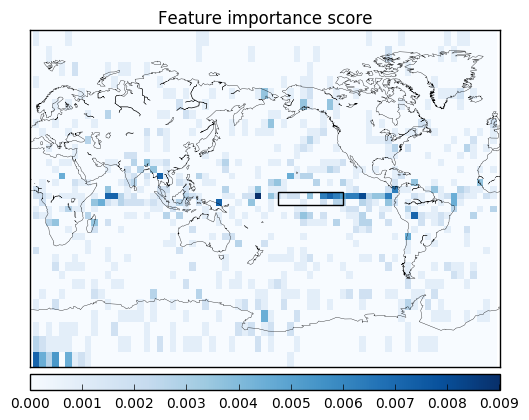

In [29]:
def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = list(zip(x, y))
    poly = Polygon(xy, edgecolor='black', fill=False)
    plt.gca().add_patch(poly)

lons, lats = np.meshgrid(X_ds['lon'], X_ds['lat'])

fig = plt.figure()
ax = fig.add_axes([0.05, 0.05, 0.9,0.9])
map = Basemap(llcrnrlon=0, llcrnrlat=-89, urcrnrlon=360, urcrnrlat=89, projection='mill')
map.drawcoastlines(linewidth=0.25)
my_cmap = plt.cm.get_cmap('afmhot_r')
im = map.pcolormesh(lons, lats,
                    reg.clf.feature_importances_[:-1].reshape((37, 72)),
                    shading='flat', cmap=plt.cm.Blues, latlon=True)
cb = map.colorbar(im,"bottom", size="5%", pad="2%")
draw_screen_poly(el_nino_lats, el_nino_lons, map)
ax.set_title("Feature importance score")
plt.show()

- It seems that there is a bias towards first columns of the array, meaning lowest lat and lon. Surprising.
    - In order to remove the bias, I tried to shuffle columns in the training array (uncomment lines of code in the above FeatureExtractor). **Results are not that better. Worse, they are very depending on the permutation**.
    - Leads to think that xgboost is sensitive to feature ordering (surprising)
----
- As observed in descriptive data, temperature in the EN zone looks pretty correlated to what's happening in the east side of the zone !
- More surprisingly, what's happening in the west part of the Indian ocean seems to affect EL temperature.
- In any case, EN zone is mostly affected by what's happening around the equator.
    - This supports papers I have read about how **horizontal** wind affects climate, especially near equator.
    - Besides, the wind force was one of the feature in "ClimateLearn: A machine-learning approach for climate prediction using network measures"
----
- Next step was to leverage most important features
- A simple trick was to take into account only these most important features.
- They were retrieved based on the fitting of the whole training set.
- The way it is implemented is pretty ugly as it is set in a hard fashion, but it is convenient for the submission process.

In [30]:
mask = np.where(reg.clf.feature_importances_ > 0.002)

In [31]:
import numpy as np
import pandas as pd
import xarray as xr

mask = np.array([   0,    1,    2,    3,    5,   72,  251,  345,  378,  385,  823,
         921, 1010, 1011, 1017, 1054, 1058, 1059, 1088, 1100, 1102, 1121,
        1122, 1130, 1138, 1147, 1157, 1209, 1216, 1222, 1223, 1233, 1234,
        1237, 1246, 1252, 1257, 1270, 1271, 1274, 1278, 1288, 1307, 1308,
        1309, 1319, 1330, 1332, 1338, 1340, 1341, 1342, 1343, 1344, 1345,
        1346, 1347, 1348, 1349, 1350, 1360, 1379, 1397, 1402, 1423, 1429,
        1433, 1455, 1476, 1477, 1483, 1487, 1498, 1508, 1516, 1531, 1537,
        1551, 1553, 1554, 1600, 1602, 1629, 1671, 1673, 1685, 1855, 1866,
        1880, 1914, 2052, 2099, 2201, 2205, 2267, 2664])

# El nino zone
en=[-5, 5, 190, 240]

# Around zones
bottom=[-15,-5,190,240]
up=[5, 15, 190, 240]
left=[-15,15,165,190]
right=[-15,15,240,250]

rectangle=[bottom[0], up[1], left[2], right[3]] # Including all zones

pac_lat_bottom = -60
pac_lat_top = 60
pac_lon_left = 360 - 220
pac_lon_right = 360 - 80

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120

def get_area(tas, coords):
    return tas.loc[:,coords[0]:coords[1], coords[2]:coords[3]]
    
def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat','lon'))

def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)

class FeatureExtractor(object):

    def __init__(self):
        pass
        
    def transform(self, X_ds):
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        
        worldwide = X_ds['tas'].values
        worldwide_vectorized = worldwide.reshape(len(worldwide), -1)
        X_array = worldwide_vectorized
        X_array = X_array[valid_range]
        
        #np.random.seed(45)
        #permutation = np.random.permutation(X_array.shape[1])
        #X_array = X_array[:,permutation]
        
        enso = get_enso_mean(X_ds['tas'])
        enso_rolled_last_year = np.roll(enso, 12 - X_ds.n_lookahead)[valid_range].reshape((-1, 1))
        
        X_array = np.concatenate([X_array,
                                  enso_rolled_last_year], axis=1)
        X_array = X_array[:,mask]
        return X_array

In [32]:
#train_process()

- As one may see, **results look pretty promising**, as it outperforms the previous model by 0.015.
- Unfortunately, such a technique may seen as overfitting, as it did not score on the leaderboard as well as the local run.

<a id='ccl'></a>
## Conclusion

- I got my best score submitting the whole map + the mean in the EN zone, using XGBoost.
- Main part of the work was to trick XGBoost, using a grid search.

-----

- I tried a whole bunch of methods on the data in order to feature engineer them:
    - Using more or less the past
    - Using different geographic areas
    - Randomize features a little bit, ...
- My last but simple feature engineering - dropping useless feature - **looked pretty promising locally**. But surprisingly, it did not behave well once tested against the leaderboard, since I got worse performance.
    
-----
- The most promising idea inspired by http://www.geosci-model-dev-discuss.net/gmd-2015-273/gmd-2015-273.pdf did not work at all, and it is very disappointing. Did not have time to dig a little more into it.

-----
- My conclusions would be:
    - Not the smartest idea will win the challenge for sure, given what simple techniques can achieve
    - **Brute force revealed pretty efficient, and XGBoost once again proved how powerful it is when it comes to feature selection.**